# TensorFlow Keras CIFAR10 Classifier - Local Example

_**Train and export a TF.Keras CNN classifier for (a subset of) the [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10) dataset: Performing all storage and computation locally on the notebook.**_

This notebook works well with the `Python 3 (TensorFlow 1.15 Python 3.7 CPU Optimized)` kernel on SageMaker Studio, or `conda_tensorflow_p36` on classic SageMaker Notebook Instances.

---

The [dataset](https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz) is hosted in the [Registry of Open Data on AWS](https://registry.opendata.aws/fast-ai-imageclas/) and contains PNG images organized in folders by which digit they represent.

>❓*Can you figure out how to re-create this notebook's workflow using SageMaker more effectively?*

## Contents

1. **[Prepare the Data](#Prepare-the-Data)**
1. **[Load the Data From File](#Load-the-Data-From-File)**
1. **[Pre-Process the Data for our CNN](#Pre-Process-the-Data-for-our-CNN)**
1. **[Build a Model](#Build-a-Model)**
1. **[Fit the Model](#Fit-the-Model)**
1. **[Save the Trained Model](#Save-the-Trained-Model)**
1. **[Explore Results](#Explore-Results)**

See the accompanying **Instructions** notebook for more guidance!

In [2]:
# First install some libraries which might not be available across all kernels (e.g. in Studio):
!pip install ipywidgets matplotlib

  Using cached ipywidgets-7.7.1-py2.py3-none-any.whl (123 kB)
  Using cached widgetsnbextension-3.6.1-py2.py3-none-any.whl (1.6 MB)
  Using cached jupyterlab_widgets-1.1.1-py3-none-any.whl (245 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached nest_asyncio-1.5.5-py3-none-any.whl (5.2 kB)
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Using cached entrypoints-0.4-py3-none-any.whl (5.3 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

%matplotlib inline

print(f"Using TensorFlow version {tf.__version__}")
print(f"Keras version {tf.keras.__version__}")


Using TensorFlow version 2.3.2
Keras version 2.4.0


## Prepare the Data

Now let's download the image data.

The original CIFAR10 data has 60,000 small 32X32X3 pixel PNG files (50,000 in the training dataset, and 10,000 in the test dataset). This format is nice and familiar - but a large number of tiny files is inefficient for storage and transfer - so **to keep things performant** we will:

- Download the data to a local temporary folder under `/tmp` (meaning you won't see the files in the left sidebar in SageMaker)
- Sample just a subset of the data to work with.

In [4]:
target_path = "/tmp/cifar10"
training_dir = f"{target_path}/train"
testing_dir = f"{target_path}/test"

# Download the CIFAR10 data from the Registry of Open Data on AWS
!rm -rf {target_path}
!mkdir -p {target_path}
!aws s3 cp s3://fast-ai-imageclas/cifar10.tgz {target_path} --no-sign-request

# Un-tar the CIFAR10 data, stripping the leading path element; this will leave us with directories
# {target_path}/testing/ and {target_path/training/
!tar zxf {target_path}/cifar10.tgz -C {target_path}/ --strip-components=1 --no-same-owner
!rm -f {target_path}/cifar10.tgz

# Get the list of files in the training and testing directories recursively
train_files = sorted(list(glob.iglob(os.path.join(training_dir, "*/*.png"), recursive=True)))
test_files = sorted(list(glob.iglob(os.path.join(testing_dir, "*/*.png"), recursive=True)))

print(f"Training files: {len(train_files)}")
print(f"Testing files:  {len(test_files)}")

# Reduce the data by keeping every Nth file and dropping the rest of the files.
reduction_factor = 1
train_files_to_keep = train_files[::reduction_factor]
test_files_to_keep = test_files[::reduction_factor]

print(f"Training files kept: {len(train_files_to_keep)}")
print(f"Testing files kept:  {len(test_files_to_keep)}")

# Delete all the files not to be kept
for fname in (set(train_files) ^ set(train_files_to_keep)):
    os.remove(fname)

for fname in (set(test_files) ^ set(test_files_to_keep)):
    os.remove(fname)

print("Done!")

download: s3://fast-ai-imageclas/cifar10.tgz to ../../../tmp/cifar10/cifar10.tgz
Training files: 50000
Testing files:  10000
Training files kept: 50000
Testing files kept:  10000
Done!


## Load Reduced Data From Files

Now our images are stored in the `{target_path}` folder, let's read our training and testing sets in from these files.

```
    {target_path}
    |----------------.
    `-- test           `-- train
        |-- airplane       |-- airplane 
        |                      `-- 1.png
        |-- automobile     |-- automobile   
        |-- bird           |-- bird
        |-- cat            |-- cat
        |-- deer           |-- deer
        |-- dog            |-- dog
        |-- frog           |-- frog
        |-- horse          |-- horse
        |-- ship           |-- ship
        `-- truck          `-- truck
```

(For both training and testing) We'll loop through each folder taking the target label (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) from the folder name and loading each PNG into an image matrix.

In [5]:
from PIL import Image
labels = sorted(os.listdir(training_dir))
n_labels = len(labels)

x_train = []
y_train = []
x_test = []
y_test = []
print("Loading label ", end="")
for ix_label in range(n_labels):
    label_str = labels[ix_label]
    print(f"{label_str}...", end="")
    trainfiles = filter(
        lambda s: s.endswith(".png"),
        os.listdir(os.path.join(training_dir, label_str))
    )    

    for filename in trainfiles:
        # Can't just use tf.keras.preprocessing.image.load_img(), because it doesn't close its file
        # handles! So get "Too many open files" error... Grr
        with open(os.path.join(training_dir, label_str, filename), "rb") as imgfile:
            x_train.append(
                # Squeeze (drop) that extra channel dimension, to be consistent with prev format:
                np.squeeze(tf.keras.preprocessing.image.img_to_array(
                    Image.open(imgfile)
                ))
            )
            y_train.append(ix_label)

    # Repeat for test data:
    testfiles = filter(
        lambda s: s.endswith(".png"),
        os.listdir(os.path.join(testing_dir, label_str))
    )

    for filename in testfiles:
        with open(os.path.join(testing_dir, label_str, filename), "rb") as imgfile:
            x_test.append(
                np.squeeze(tf.keras.preprocessing.image.img_to_array(
                    Image.open(imgfile)
                ))
            )
            y_test.append(ix_label)
print()


print("Shuffling trainset...")
train_shuffled = [(x_train[ix], y_train[ix]) for ix in range(len(y_train))]
np.random.shuffle(train_shuffled)

x_train = np.array([datum[0] for datum in train_shuffled])
y_train = np.array([datum[1] for datum in train_shuffled])
train_shuffled = None

print("Shuffling testset...")
test_shuffled = [(x_test[ix], y_test[ix]) for ix in range(len(y_test))]
np.random.shuffle(test_shuffled)

x_test = np.array([datum[0] for datum in test_shuffled])
y_test = np.array([datum[1] for datum in test_shuffled])
test_shuffled = None

print("Done!")

Loading label airplane...automobile...bird...cat...deer...dog...frog...horse...ship...truck...
Shuffling trainset...
Shuffling testset...
Done!


**Before we go ahead**, let's just quickly visualize the data distribution.

x_train.shape (50000, 32, 32, 3); dtype float32
y_train.shape (50000,); dtype int64
x_test.shape (10000, 32, 32, 3); dtype float32
y_test.shape (10000,); dtype int64


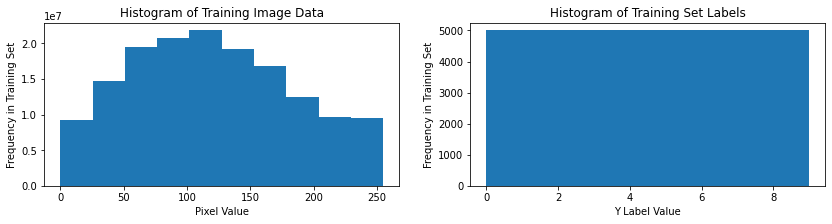

In [6]:
print(f"x_train.shape {x_train.shape}; dtype {x_train.dtype}")
print(f"y_train.shape {y_train.shape}; dtype {y_train.dtype}")
print(f"x_test.shape {x_test.shape}; dtype {x_test.dtype}")
print(f"y_test.shape {y_test.shape}; dtype {y_test.dtype}")

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
#plt.hist(x_train_raw.flatten())
plt.hist(x_train.flatten())
ax.set_title("Histogram of Training Image Data")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Pixel Value")

ax = plt.subplot(1, 2, 2)
plt.hist(y_train)
ax.set_title("Histogram of Training Set Labels")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Y Label Value")

plt.show()

It looks like the data is pretty evenly distributed between labels 0-9, and our images are encoded by fixed-size 32x32x3 matrices from 0 to 255. Here we will just plot a few examples to get a feel for them:

Some example images:


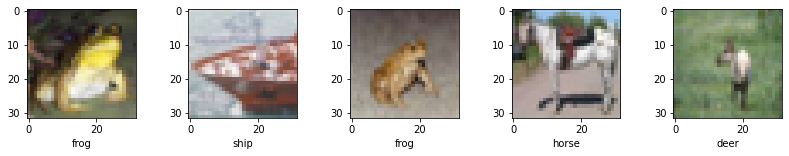

In [21]:
print("Some example images:")
fig = plt.figure(figsize=(14, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.array(x_train[i], np.int32), cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

## Pre-Process the Data for our CNN

Next, we'll tweak this format for our neural network:

- Normalizing pixel values to improve the numerical conditioning
- One-hot encoding our labels to suit a softmax classifier output of probabilities for each digit
- Adding both a batch dimension (for processing multiple samples in parallel) and a channel dimension (e.g. as if this were a 3-channel RGB image, except single-channel for grayscale) - as well as the X and Y axes.

In [27]:
# by default, it's channel_last for keras backend data format
print(f"training data set shape: {x_train.shape}")
print(K.image_data_format())

if 'channels_last' != K.image_data_format():
    print("use 'channels_last' data format...")
    K.set_image_data_format('channels_last')

training data set shape: (50000, 32, 32, 3)
channels_last


In [28]:
# convert dataset matrix to be float32 and normalize them by 255
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]

print("x_train shape:", x_train.shape)
print("input_shape:", input_shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, n_labels)
y_test = tf.keras.utils.to_categorical(y_test, n_labels)

print("n_labels:", n_labels)
print("y_train shape:", y_train.shape)


x_train shape: (50000, 32, 32, 3)
input_shape: (32, 32, 3)
50000 train samples
10000 test samples
n_labels: 10
y_train shape: (50000, 10)


## Build a Model

At its core, the model is a 2D convolutional network with a softmax output layer that'll yield a confidence score for every possible label (e.g. 10 options for digit = 0 to 9).


In [32]:
# clear session - making re-running in a cleaner state
K.clear_session()

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(n_labels, activation='softmax'))

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Fit the Model

Keras makes fitting and evaluating the model straightforward enough: We don't have any fancy hooks, and are happy with the default logging:


In [ ]:
%%time
batch_size = 128
epochs = 5

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Hint: You might prefer =2 for running in SageMaker!
    validation_data=(x_test, y_test)
)

score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss={score[0]}")
print(f"Test accuracy={score[1]}")


Epoch 1/5
391/391 [==============================] - 123s 315ms/step - loss: 1.7926 - accuracy: 0.3401 - val_loss: 1.3876 - val_accuracy: 0.4957
Epoch 2/5
391/391 [==============================] - 123s 315ms/step - loss: 1.3889 - accuracy: 0.4969 - val_loss: 1.1610 - val_accuracy: 0.5854
Epoch 3/5
391/391 [==============================] - 123s 314ms/step - loss: 1.1866 - accuracy: 0.5810 - val_loss: 1.0355 - val_accuracy: 0.6260
Epoch 4/5
391/391 [==============================] - 123s 314ms/step - loss: 1.0396 - accuracy: 0.6379 - val_loss: 0.9152 - val_accuracy: 0.6819
Epoch 5/5
112/391 [=======>......................] - ETA: 1:22 - loss: 0.9807 - accuracy: 0.6625

In [ ]:
# Loss curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
plt.figure(figsize=[6, 4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

## Save the Trained Model

Keras has a built-in `model.save()` command, which in TensorFlow v2 can directly produce TensorFlow Serving-compatible outputs!

In [ ]:
# The export folder needs to be empty, or non-existent
!rm -rf data/model/model/1

model.save(os.path.join("data/model", "model/1"))

## Explore Results

Let's take a sample image from the test set, predict the label and plot it!


In [ ]:
# Choose an image:
label = "truck"
index = 0
filename = os.listdir(f"{testing_dir}/{label}")[index]

# Load the image:
img = tf.keras.preprocessing.image.img_to_array(
    Image.open(f"{testing_dir}/{label}/{filename}")
)
img = img / 255.0

# Expand out the "batch" dimension, and send to the model:
result = model.predict(img)
print(f"Result confidences: {result}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(np.squeeze(img), cmap="gray")
fig.set_title(f"Predicted Number {np.argmax(result[0])}")
plt.show()


All done! Let's move on to SageMaker notebook to experience SageMaker Training Job.